# Trabalho Prático nº4- SPHINCS+ - Grupo 8

Para o quarto e último trabalho prático da UC Estruturas Criptográficas foi nos pedido para implementar um protótipo do algoritmo Sphincs+. Este algoritmo é um dos candidatos no concurso NIST Post-Quantum Cryptography na categoria de esquemas de assinatura digital.

O algoritmo seguido foi a submissão da terceira ronda do concurso do NIST e é apresentado no website https://sphincs.org/resources.html.

O Sphincs+ é um esquema de *"Hash Based Signature"* e a sua segurança depende apenas das propriedas das funções hash que o compõe. Este algoritmo é inspirado no algoritmo XMSS e utiliza muitos componentes deste algoritmo. Contudo utiliza chaves e assinaturas maiores para eliminar a necessidade de manter um estado.

A ideia base deste algoritmo é autenticar um elevado número de pares de chaves *few-time signatures (FTS)*, chamadas hypertree. Estes esquemas FTS são um esquema de assinaturas que permite a um par de chaves gerar um pequeno número de assinaturas. Para cada mensagem, um par de chaves FTS é escolhido aleatoriamente para o assinar. A assinatura gerada será uma assinatura FTS e a informação de autenticação para o par de chaves FTS utilizado. Esta informação de autenticação será aproximadamente uma assinatura da hypertree. Estas hypertree são árvores de *many-time signatures (MTS)*. Assim, a informação de autenticação do par de chaves FTS consiste em *d* assinaturas MTS que permitem construir um percurso das chaves FTS até ao topo da árvore MTS.

O MTS consiste numa OTS (*one-time signature*) de uma certa mensagem com um percurso de autenticação de uma *hash-tree* binária. A chave pública do SPHINCS+ é essencialmente a chave pública no nível superior da hypertree. Esta corresponde apenas à raiz da hash-tree binária. A chave privada será apenas um simples valor secreto, que será utilizado para gerar todas as chaves privadas dos OTS e FTS. 

Após este pequeno contexto, passamos assim à explicação do algoritmo implementado. Na nossa solução, optamos por implementar o Sphincs-shake256-128f-simple.

## Algoritmo do Sphincs+:

O algoritmo do sphincs+ é composto por três funções:

* Uma função para a geração de chaves (spx_keygen)
* Uma função para gerar uma assinatura (spx_sign)
* Uma função para a verificação da assinatura (spx_verify)

Na definição destas funções recorremos a funções dos outros esquemas implementados (WOTS+ One-Time Signatures, XMSS, Hypertree, FORS). Destes esquemas mencionados, como já vimos o FORS corresponde a uma FTS, o WOTS+ corresponde a um OTS e a hypertree a um MTS. Posteriormente serão explicadas as diferentes funções definidas para cada esquema.

In [1]:
from math import log2, floor, ceil
from cryptography.hazmat.primitives import hashes
import copy
import os

## Auxiliar Functions

Para a implementação deste algoritmo foi necessário recorrer a duas funções auxiliares que serão utilizadas pelas funções que se seguem.

A função *toByte(x,y)* é uma destas funções. Esta função permite transformar um inteiro x na sua representação binária. A byte-string retornada terá o tamanho igual a y.

A função *base_w* é uma função que permite gerar uma função que gera um array de out_len inteiros cujo valores estão entre 0 e w-1. 

In [2]:
# Função que gera uma y-byte string que representa o valor de x
def toByte(x,y):    
    return int(x).to_bytes(y, 'big')

'''
X : len_x-byte string
w : element of {4,16,256}
Required: 8 ∗ len_X/ log(w).
'''
def base_w(X,w,out_len):    
    in_ = 0
    out_ = 0
    total_ = 0
    bits = 0
    
    basew = [0] * out_len
    
    for i in range(out_len):
        if(bits == 0):
            total = X[in_]
            in_ += 1
            bits += 8
        bits -= log2(w)
        basew[out_] = (total >> int(bits)) and (w - 1)
        out_ += 1
    return basew

## Cryptographic (Hash) Function Families & Functions Parameters

Os algoritmos que serão apresentados posteriormente necessitam de um conjunto de parâmetros. O valor dos parâmetros destes algoritmos tem um impacto na velocidade da computação do algoritmo, na memória utilizada e na segurança do algoritmos Sphincs+. Assim, os valores apresentados no documento da formulação foram determinados a partir de uma script SAGE. Os valores escolhidos para a nossa implementação foram os sugeridos no documento para a versão SPHINCS+-128f. Adicionalmente, são também calculados outros valores que serviram como parâmetros para outras funções.

O Sphincs+ utilizada também diferentes funções de hash, visto que é um esquema de *Hash-Based Signature*. As funções hash que este algoritmo irá utilizar foram divididas em duas seções, as *Tweakable Hash Functions* e as *PRF and Message Digest* que serão apresentadas de seguida.

In [3]:
# Variáveis Globais:

# SPHINCS+ - 128f:
# n: the security parameter in bytes
n = 16
# h: the height of the hypertree
h = 66
# d: the number of layers in the hypertree
d = 22
# t: the number of leaves of a FORS tree
t = 64
# k: the number of trees in FORS
k = 33
# w: the Winternitz parameter
w = 16

bitsec = 128
sec_level = 1
sig_bytes = 17088

# len: the number of n-byte string elements in a WOTS + private key, public key, and signature. It is computed as len = len 1 + len 2
len1 = ceil( (8*n) / log2(w) )
len2 = floor( log2(len1*(w - 1)) / log2(w) ) + 1
len_ = len1 + len2  

RANDOMIZE = True

### Tweakable Hash Functions:

As *Tweakable Hash Functions* são funções que recebem o valor da public_key_seed, da *address* e da mensagem. A *address* corresponde ao contexto da informação e será definida numa estrutura que será introduzida posteriormente. Nesta solução foram definidas três funções desta categoria que seguem a seguinte fórmula.

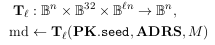

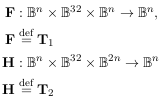

No documento com a formulação do algoritmo foram apresentadas propostas para estas funções hash. Na solução implementada utilizamos as funções que recorrem ao SHAKE256 na variante simples. Para a nossa implementação usamos a função SHAKE256 do cryptography.

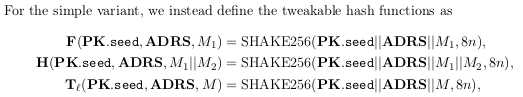

In [4]:
## Simple Variant
def F(PK_seed, ADRS, M1):
    shake = hashes.Hash(hashes.SHAKE256(int(n)))
    shake.update(PK_seed + ADRS + M1)
    return shake.finalize()

def H(PK_seed, ADRS, Ma): # Ma = M1 + M2
    shake = hashes.Hash(hashes.SHAKE256(int(n)))
    shake.update(PK_seed + ADRS + Ma)
    return shake.finalize()

def T_l(PK_seed, ADRS, M): 
    shake = hashes.Hash(hashes.SHAKE256(int(n)))
    shake.update(PK_seed + ADRS + M)
    return shake.finalize()

### PRF and Message Digest: 

Para além das Tweakable Hash Functions, este algoritmo recorre a pseudorandom functions (PRF) e message digest functions. As funções que pertencem a esta categoria são a PRF, a PRF_msg e a H_msg. A PRF é utilizada para gerar uma chave pseudorandom, a PRF_msg para gerar aleatoriadade na compressão de mensagens e a H_msg é uma função hash que utiliza uma chave e permite a compressão de uma mensagem.







As funções utilizadas para esta solução são apresentadas pertencem à versão SPHINCS+-SHAKE256, e são apresentadas na secção 7.2.1 da formulação.

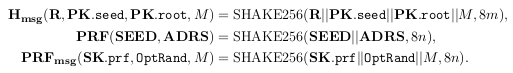

In [5]:
# SPHINCS+ - SHAKE 256:
# R, PK_seed, PK_root, M : byte-strings
def H_msg(R, PK_seed, PK_root, M, m):
    shake = hashes.Hash(hashes.SHAKE256(int(m)))
    shake.update( R + PK_seed + PK_root + M)
    return shake.finalize()

# SEED, ADRS : byte-strings
def PRF(SEED, ADRS):
    shake = hashes.Hash(hashes.SHAKE256(int(n)))
    shake.update(SEED + ADRS)
    return shake.finalize()
    
# SK_prf, OptRand, M: byte-strings
def PRF_msg(SK_prf, OptRand, M):
    shake = hashes.Hash(hashes.SHAKE256(int(n)))
    shake.update(SK_prf + OptRand + M)
    return shake.finalize()

### Hash Function Address Scheme (Structure of ADRS):

A estrutura ADRS é uma string de 32-bytes que aponta um endereço e segue uma estrutura bem definida. Esta será utilizada por todas as funções para registar o contexto atual e atualizar os endereços depois da execução das funções hash. Esta estrutura será utilizada para 5 funcionalidades diferentes. Estas são apresentadas de seguida:

1. "Used for the hashes in WOTS+ schemes"
2. "Used for compression of the WOTS+ public key"
3. "Used for hashes within the main Merkle tree construction"
4. "Used for the hashes in the Merkle tree in FORS"
5. "Used for the compression of the tree roots of FORS"

Estas cinco funcionalidades recorrem a cinco formatos diferentes desta estrutura. Estes formatos são apresentados de seguida.

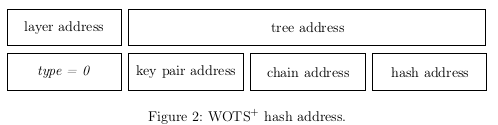

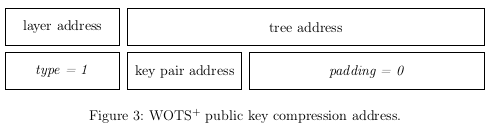

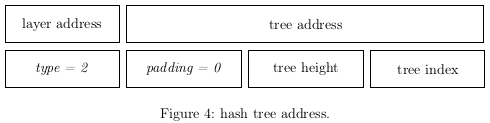

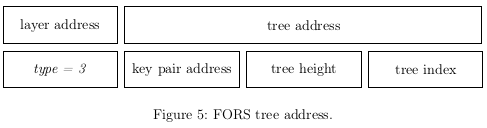

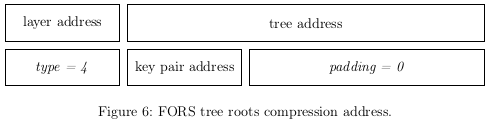

Cada uma das *"caixas"* mais pequenas correspondem a 4 bytes e a *"caixas"* do parâmetro *tree address* corresponde a 12 bytes. Cada uma destas caixas irá armazena a representação em bytes de um inteiro. Esta representação binária seguirá uma notação *big-endian*.

As funções *set* definidas se seguida guardam numa dada posição do array ADRS os valores bytes indicados. Para além disso, é indicado na formulação que a função *setType()* deverá receber uma das constantes definidas (WOTS_HASH, WOTS_PK, TREE, FORS_TREE e FORS_ROOTS) e colocar os últimos três *"blocos"* a zero.

In [6]:
# TIPOS DE ADDRESS:
'''
0: WOTS + hash address
1: compression of the WOTS + public key
2: hash tree address
3: FORS address
4: compression of FORS tree roots
'''
WOTS_HASH  = 0
WOTS_PK    = 1
TREE       = 2
FORS_TREE  = 3
FORS_ROOTS = 4


# ESTRUTURA DA ADRS:
# [0:4]: layer address
# [4:16]: tree address
# [16:20]: type {0,1,2,3,4}

'''
0: WOTS_HASH
    [20:24]: key pair address
    [24:28]: chain address
    [28:32]: hash address
'''

'''
1: WOTS_PK
    [20:24]: key pair address
    [24:32]: padding = 0
'''

'''
2: TREE
    [20:24]: padding = 0
    [24:28]: tree height
    [28:32]: tree index
'''

'''
3: FORS_TREE
    [20:24]: key pair address
    [24:28]: tree height
    [28:32]: tree index
'''

'''
4: FORS_ROOTS
    [20:24]: key pair address
    [24:32]: padding
'''


class ADRS:    
    def __init__(self):
        self.adsr = bytearray(toByte(0,32))

    def setLayerAddress(self, val):
        self.adsr[0:4] = val
    
    def setTreeAddress(self, val):
        self.adsr[4:16] = val
    
    def setType(self, type_):
        self.adsr[16:20] = type_
        self.adsr[20:32] = toByte(0, 12)
        
    def setKeyPairAddress(self, key_pair_address):
        self.adsr[20:24] = key_pair_address
        
    def getKeyPairAddress(self):
        return self.adsr[20:24]
    
    def setChainAddress(self, i):
        self.adsr[24:28] = i
        
    def setHashAddress(self, val):
        self.adsr[28:32] = val
    
    def setTreeHeight(self, value):
        self.adsr[24:28] = value
        
    def getTreeHeight(self):
        return self.adsr[24:28]
    
    def setTreeIndex(self, value):
        self.adsr[28:32] = value
    
    def getTreeIndex(self):
        return self.adsr[28:32]
    
    def getBytes(self):
        return bytes(self.adsr)


## WOTS+ One-Time Signatures

O WOTS+ é um algoritmo de *One-time Signature*. Visto que é um algoritmo de assinatura deste tipo, a chave privada utilizada para estas assinaturas só poderá ser **usada uma única vez**. Se esta for usada para assinar múltiplas mensagens, este esquema torna-se inseguro.

Este algoritmo é composto por quatro partes principais:
1. *Chaining function*, que corresponde ao building block principal deste esquema.
2. Função que permite gerar as chaves pública e privada.
3. Função que permite gerar a assinatura WOTS+.
4. Função que permite obter a chave pública a partir da assinatura do WOTS+.

Os parâmetros deste esquema são **n**, **w** e **len**. O **n** corresponde ao parâmetro de segurança e o comprimento da mensagem, da chave privada, chave pública e da assinatura em bytes. O **w** corresponde ao parâmetro Winternitz e deve pertencer ao conjunto {4,16,256}, visto que estes valores são os que levam a um melhor *trade-off* entre segurança e velocidade de resolução. Por último, o parâmetro **len** coresponde ao número de elementos n-byte-string na chave privada, na chave pública e na assinatura WOTS+.

A função *chain* calcula o valor das *s* iterações da função *hash* **F**, cujo o *input* é o valor da chave pública e do contexto *ADRS*.

A função *wots_SKgen* gera a chave privada do esquema WOTS+. Esta chave corresponde a um array de tamanho **len**, cujo cada valor *i* é derivada da *secret seed* do SPHINCS+ e da *ADRS*. Cada um dos elementos da chave privada do WOTS+ codifica a posição do *hash chain* i.

A função *wots_PKgen* gera uma chave pública do WOTS+. Esta chave pública é composta pelo nó final da *hash chains*. Para gerar estes valores é utilizada a função *chain* e deve receber a *ADRS* que codifica a posição do par de chaves na estrutura SPHINCS+.

A função *wots_sign* gera uma assinatura para uma dada mensagem utilizando a *seed* privada e pública. Esta assinatura gerada será um array de tamanhho len. Esta assinatura é gerada obtendo um valor *checksum* do *base_w* da mensagem. O *base_w* do checksum é concatenado com o valor do *base_w* mensagem. A assinatura será obtida a partir dos nós selecionados. Estes nós serão selecionados pela utilização dos inteiros base_w em diferentes *hash chain*.

A função *wots_pkFromSig* obtem o valor da chave pública a partir do valor da assinatura. Esta operação pode ser realizada *"completando"* as computações da função *chain*, começando no valor da assinatura e usando os valores da função *base-w* sobre a hash da mensagem e o seu checksum. Esta função pode ser usada para verificar a assinatura WOTS+. 

In [7]:
class WOTS:
    def __init__(self, n, w, len1, len2, len_):
        self.n = n
        self.w = w
        self.len1 = len1
        self.len2 = len2
        self.len_ = len_
    
    # Input: Input string X, start index i, number of steps s, public seed PK.seed (n-byte string), address ADRS (32-byte string)
    # Output: value of F iterated s times on X
    def chain(self, X, i, s, PK_seed, ADRS):
        if s == 0:
            return bytes(X)
        if (i + s) > (self.w - 1):
            return -1
        
        tmp = self.chain(X, i , s-1, PK_seed, ADRS)
        ADRS.setHashAddress(toByte(i + s - 1, 4)) # address is updated to encode the current position
        tmp = F(PK_seed, ADRS.getBytes(), tmp)
        return tmp
        
        
    # Input: secret seed SK.seed, address ADRS
    # Output: WOTS+ private key sk : length len_ array of n-byte strings
    def wots_SKgen(self, SK_seed, ADRS):
        sk = []
        for i in range(self.len_): # POSSIVEL ERRO?
            ADRS.setChainAddress(toByte(i,4))
            ADRS.setHashAddress(toByte(0,4))
            sk.append(PRF(SK_seed, ADRS.getBytes())) # Returns a byte-string size n            
        return sk
    
    
    #Input: secret seed SK.seed, address ADRS, public seed PK.seed
    #Output: WOTS+ public key pk
    def wots_PKgen(self, SK_seed, PK_seed, ADRS):
        wotspkADRS = copy.deepcopy(ADRS) # copy address to create OTS public key address
        tmp = bytes()
                
        for i in range(self.len_): 
            ADRS.setChainAddress(toByte(i,4))
            ADRS.setHashAddress(toByte(0,4))
            sk = PRF(SK_seed, ADRS.getBytes())
            tmp += bytes(self.chain(sk, 0, self.w - 1, PK_seed, ADRS))
        
        wotspkADRS.setType(toByte(WOTS_PK, 4))
        wotspkADRS.setKeyPairAddress(ADRS.getKeyPairAddress())
        pk = T_l(PK_seed, wotspkADRS.getBytes(),  tmp)
        return pk
    
    
    def wots_sign(self, M, SK_seed, PK_seed, ADRS):
        # convert message to base w
        msg = base_w(M, self.w, self.len1)
        
        # compute checksum
        csum = 0
        for i in range(self.len1):
            csum += self.w - 1 - msg[i]
    
        # convert csum to base w
        if( (log2(self.w) % 8) != 0):
            csum = csum << ( 8 - ( ( self.len2 * log2(self.w) ) % 8 ))

        len_2_bytes = ceil( ( self.len2 * log2(self.w) ) / 8 )
        msg += base_w(toByte(csum, len_2_bytes),self.w, self.len2)
        sig = []
        for i in range(self.len_):
            ADRS.setChainAddress(toByte(i, 4))
            ADRS.setHashAddress(toByte(0,4))
            sk = PRF(SK_seed, ADRS.getBytes())
            sig += [self.chain(sk, 0, msg[i], PK_seed,ADRS)]
    
        return sig
    

    #Input: Message M, WOTS+ signature sig, address ADRS, public seed PK.seed
    #Output: WOTS+ public key pk_sig derived from sig
    def wots_pkFromSig(self, sig, M, PK_seed, ADRS):
        csum = 0
        wotspkADRS = copy.deepcopy(ADRS)
         
        # convert message to base w
        msg = base_w(M, self.w, self.len1)
        
        # compute checksum
        for i in range(self.len1):
            csum += self.w - 1 - msg[i]
        
        # convert csum to base w
        csum = csum << ( 8 - ( ( self.len2 * log2(self.w) ) % 8 ))
        len_2_bytes = ceil( ( self.len2 * log2(self.w) ) / 8 )
        msg += base_w(toByte(csum, len_2_bytes), self.w, self.len2)
        
        tmp = bytes()
        for i in range(self.len_):
            ADRS.setChainAddress(toByte(i, 4))
            tmp += self.chain(sig[i], msg[i], self.w - 1 - msg[i], PK_seed,ADRS)
        
        wotspkADRS.setType(toByte(WOTS_PK, 4))
        wotspkADRS.setKeyPairAddress(ADRS.getKeyPairAddress())
        pk_sig = T_l(PK_seed, wotspkADRS.getBytes(), tmp)
        return pk_sig

## The SPHINCS+ Hypertree

A implementação das hypertree do Sphincs+ pode ser dividida em duas fazes. A primeira definimos o WOTS+ que é combinado com uma árvore de hash binária para definir uma versão do XMSS com input de tamanho fixo. De seguida, obtemos a hypertree. Esta hypertree corresponde a uma versão de uma *multi-tree XMSS*.

### (Fixed Input-Length) XMSS:

XMSS é baseado no esquema de assinaturas de Merkle e permite assinar um número potencialmente elevado mas fixo de mensagens. Esta possui 2^h chaves públicas numa árvore com h de altura, e portanto pode ser utilizada para assinar 2^h mensagens. Cada nó corresponde à hash da concatenação dos seus filhos e cada folha corresponde a uma chave pública WOTS+. A raiz desta àrvore é uma chave pública XMSS. A chave privada do XMSS será utilizada para gerar todas as chaves privadas do WOTS+.

No SPHINCS+, a assinatura XMSS corresponde ao *path* de autenticação e é composto pelas assinaturas WOTS+. Ou seja, a assinatura XMSS corresponde a um vetor dos nós que permite determinar o valor da raiz de uma àrvore que comece pela assinatura WOTS+. Com o valor da raz é possível verificar se um 

Os parâmetros do XMSS são o h', que é obtido pela divisão de h por d, n e w, que será utilizado no esquema WOTS+.

A função *treehash* permite determinar os valores dos nós internos da àrvore de Merkle. Sabendo que nestas àrvores a altura das folhas é 0, esta função retorna a raiz da àrvore que se encontra na altura z, sabendo que a folha mais à esquerda corresponde à chave pública do WOTS+ na posição s.

A função *xmss_PKgen* gera a chave pública XMSS que no contexto deste algoritmo é a raiz da àrvore hash binária. Para tal recorre à função *treehash*.

A assinatura deste algoritmo corresponde à assinatura do esquema WOTS+ e ao *path* de autenticação da folha associada ao par de chaves WOTS+ utilizado. A função *xmss_sign* é utilizada para gerar o valor da assinatura XMSS.

A função *xmss_pkFromSig* gera a chave pública XMSS candidata a partir da assinatura XMSS. Esta pode ser utilizada em comparações para verificar se o resultado da assinatura é o esperado. Para tal, é utilizada a função *wots_pkFromSig* para determinar uma chave pública WOTS+ candidata, que juntamente com o path de autenticação determina a raiz.

In [8]:
class XMSS:
    def __init__ (self, h_, n, w):
        self.h_ = h_
        self.n = n
        self.w = w
        self.wots = WOTS(n,w, len1, len2, len_)
         
    # It is REQUIRED that s % 2^z = 0
    # Input: Secret seed SK_seed, start index s, target node height z, public seed PK_seed, address ADRS
    # Output: n-byte root node - top node on Stack
    def treehash(self, SK_seed, s, z, PK_seed, ADRS):
        if s % (1 << z) != 0 :
            return -1
    
        stack = []
    
        for i in range(2**z):
            ADRS.setType(toByte(WOTS_HASH, 4))
            ADRS.setKeyPairAddress(toByte(s + i, 4))
            node = self.wots.wots_PKgen(SK_seed, PK_seed, ADRS)
            
            ADRS.setType(toByte(TREE, 4))
            ADRS.setTreeHeight(toByte(1, 4))
            ADRS.setTreeIndex(toByte(s + i, 4))
            
            if len(stack) > 0:
                while bytes(stack[len(stack)-1][1]) == bytes(ADRS.getTreeHeight()): # !!!!!!!!!!!!!!!!!
                    tree_idx = int.from_bytes(ADRS.getTreeIndex(),'big')
                    
                    ADRS.setTreeIndex(toByte((( tree_idx - 1) // 2), 4))
                    aux = stack.pop()[0] + node
                    node = H(PK_seed, ADRS.getBytes(), aux)
                    tree_h = int.from_bytes(ADRS.getTreeHeight(),'big')
                    ADRS.setTreeHeight(toByte( tree_h + 1 ,4))

                    if len(stack) <= 0:
                        break
                    
            stack.append((node, ADRS.getTreeHeight())) #push
            
        return stack.pop()[0]

    
    # Input: Secret seed SK.seed, public seed PK.seed, address ADRS
    # Output: XMSS public key PK
    def xmss_PKgen(self, SK_seed, PK_seed, ADRS):
        pk = self.treehash(SK_seed, 0, self.h_, PK_seed, ADRS)
        return pk

    
    # Input: n-byte message M, secret seed SK.seed, index idx, public seed PK.seed, address ADRS
    # Output: XMSS signature SIG_XMSS = (sig || AUTH)
    def xmss_sign(self, M, SK_seed, idx, PK_seed, ADRS):
        AUTH = []
    
        # build authentication path
        for j in range(self.h_):
            k_aux = floor(idx // 2**j)
            k = k_aux ^^ 1 # If it is bytes, i need to change this
            AUTH += [self.treehash(SK_seed, k * 2**j, j, PK_seed, ADRS)]
            
        ADRS.setType(toByte(WOTS_HASH, 4))
        ADRS.setKeyPairAddress(toByte(idx, 4))
        
        sig = self.wots.wots_sign(M, SK_seed, PK_seed, ADRS)
        SIG_XMSS = sig + AUTH
        return SIG_XMSS

    
    # Input: index idx, XMSS signature SIG_XMSS = (sig || AUTH), n-byte message M, public seed PK.seed, address ADRS
    # Output: n-byte root value node[0]
    def xmss_pkFromSig(self, idx, SIG_XMSS, M, PK_seed, ADRS):
        
        # compute WOTS+ pk from WOTS+ sig
        ADRS.setType(toByte(WOTS_HASH, 4))
        ADRS.setKeyPairAddress(toByte(idx,4))
        
        sig = SIG_XMSS[:len_]
        AUTH = SIG_XMSS[len_:]
        
        
        node0 = self.wots.wots_pkFromSig(sig, M, PK_seed, ADRS)
        node1 = 0
        
        # compute root from WOTS+ pk and AUTH
        ADRS.setType(toByte(TREE,4))
        ADRS.setTreeIndex(toByte(idx,4))
        
        for i in range(self.h_):
            ADRS.setTreeHeight(toByte(i+1, 4))
            
            tree_idx = int.from_bytes(ADRS.getTreeIndex(),'big')
            if (floor(idx / 2**i) % 2) == 0:
                ADRS.setTreeIndex( toByte( tree_idx // 2 , 4) )
                node1 = H(PK_seed, ADRS.getBytes(), node0 + AUTH[i])
            else:
                ADRS.setTreeIndex( toByte( (tree_idx - 1) // 2 , 4) )
                node1 = H(PK_seed, ADRS.getBytes(), AUTH[i] + node0)
            node0 = node1
        return node0

### HT: The Hypertree

A *Hypertree (HT)* do Sphincs+ é essencial uma árvore de certificação de instâncias XMSS. Uma HT é uma árvore composta por várias camadas de árvores XMSS, onde apenas os elementos das árvores a um nível mais baixo poderão assinar as mensagens.

Para além dos parâmetros do XMSS, as *Hypertree* precisam também da altura h, do número de camadas d. 

A função *ht_PKgen* permite gerar a chave pública da HT. Esta corresponde à raiz da única árvore XMSS que se encontra na camada superior.

A função *ht_sign* permite gerar o valor da assinatura HT. Esta assinatura é composta por *d* assinaturas XMSS e o seu formato é apresentado na imagem seguinte:

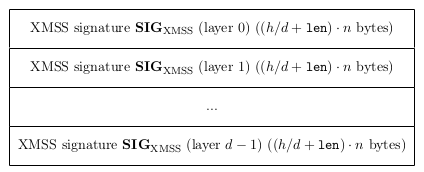

Esta função invoca a função *xmss_sign* e guarda o resultado destas invocações numa *stack*. O argumento idx da função identifica a folha da Hypertree que será usada para assinar a mensagem.
 
A função *ht_verify* permite verificar a assinatura HT indicada. Esta corresponde a *d* chamadas da função *xmss_pkFromSig*.

In [9]:
class HT:
        
    def __init__(self, h, n, w, d):
        self.h = h
        self.n = n
        self.w = w
        self.d = d
        self.len_ = len_
        self.xmss = XMSS(h/d, n, w)
        
        
    # Input: Private seed SK.seed, public seed PK.seed
    # Output: HT public key PK_HT
    def ht_PKgen(self, SK_seed, PK_seed):
        adrs = ADRS()
        adrs.setLayerAddress(toByte(self.d-1, 4))
        adrs.setTreeAddress(toByte(0, 12))
        root = self.xmss.xmss_PKgen(SK_seed, PK_seed, adrs)
        return root
    
    # Input: Message M, private seed SK.seed, public seed PK.seed, tree index idx_tree, leaf index idx_leaf
    # Output: HT signature SIG_HT
    def ht_sign(self, M, SK_seed, PK_seed, idx_tree, idx_leaf):
        # init
        adrs = ADRS()
                
        adrs.setLayerAddress(toByte(0, 4))
        adrs.setTreeAddress(toByte(idx_tree, 12))
        
        SIG_tmp = self.xmss.xmss_sign(M, SK_seed, idx_leaf, PK_seed, adrs)
        SIG_HT = SIG_tmp 
        root = self.xmss.xmss_pkFromSig(idx_leaf, SIG_tmp, M, PK_seed, adrs)
        
        for j in range(1, d):
            idx_leaf = idx_tree % 2**(self.h//self.d)
            idx_tree = idx_tree >> (self.h//self.d)
            
            adrs.setLayerAddress(toByte(j, 4))
            adrs.setTreeAddress(toByte(idx_tree, 12))
            
            SIG_tmp = self.xmss.xmss_sign(root, SK_seed, idx_leaf, PK_seed, adrs)
            SIG_HT = SIG_HT + SIG_tmp
            if j < self.d - 1:
                root = self.xmss.xmss_pkFromSig(idx_leaf, SIG_tmp, root, PK_seed, adrs)
        
        return SIG_HT
    
    
    
    # Input: Message M, signature SIG_HT, public seed PK.seed, tree index idx_tree, leaf index idx_leaf, HT public key PK_HT.
    # Output: Boolean
    def ht_verify(self, M, SIG_HT, PK_seed, idx_tree, idx_leaf, PK_HT):
        # init
        adrs = ADRS()
        
        h_ = self.h//self.d
        
        # verify
        SIG_tmp = SIG_HT[:(h_ + len_)]
        
        adrs.setLayerAddress(toByte(0,4))
        adrs.setTreeAddress(toByte(idx_tree,12))
        node = self.xmss.xmss_pkFromSig(idx_leaf, SIG_tmp, M, PK_seed, adrs)
        
        for j in range(1, self.d):
            idx_leaf = idx_tree % 2**(self.h//self.d)
            idx_tree = idx_tree >> (self.h//self.d)
            
            
            SIG_tmp = SIG_HT[ (h_ + len_)*j : (h_ + len_)*(j+1) ]
            
            adrs.setLayerAddress(toByte(j, 4))
            adrs.setTreeAddress(toByte(idx_tree,12))
            node = self.xmss.xmss_pkFromSig(idx_leaf, SIG_tmp, node, PK_seed, adrs)
            
        if node == PK_HT:
            return True
        else:
            return False

## FORS: Forest Of Random Subsets:

O algoritmo FORS é um algoritmo de *few-time signature*. As chaves públicas das instâncias deste esquema são assinadas pela HT e são utilizadas para assinar as mensagens.

No contexto do SPHINCS+, a chave FORS privada é a única seed privada SK.seed contida na chave privada do SPHINCS+.

A subrotina *fors_treehash* é utilizada para gerar os nós da hash-trees FORS. Este algoritmo é semelhante ao algoritmo *treehash* apresentado anteriormente. As diferenças para o anterior são a forma como as folhas são calculadas e como os endereços são "tratados". Esta função também retorna a raiz da árvore de altura *z* cujo nó mais à esquerda é a *hash* da chave privada no posição s.

No contexto do SPHINCS+, uma chave pública FORS é sempre gerada em conjunto com uma assinatura. O output é uma chave pública FORS. Esta chave é utilizada para completude, melhor compreensão e testes.

Uma assinatura FORS contém k valores de chaves privadas e os seus caminhos de autenticação associados. O ADRS utilizado para gerar esta assinatura contém a posição da instância FORS no SPHINCS+. O output é uma assinatura FORS.

A função *fors_pkFromSig* é composta por duas fases. Primeiro são geradas as k raizes da *hash tree* utilizando a função *fors_treehash* e de seguida, as raizes são utilizadas como argumento de uma função hash. Esta função utiliza a assinatura FORS para gerar uma chave pública candidata FORS. Esta chave pública obtida é utilizada numa comparação, para assim verificar a correção da solução desta esquema.

In [10]:
class FORS:
    
    def __init__(self, n, k, t):
        self.n = n
        self.k = k
        self.t = t
        
    #Input: secret seed SK.seed, address ADRS, secret key index idx = it+j
    #Output: FORS private key sk
    def fors_SKgen(self, SK_seed, ADRS, idx):
        ADRS.setTreeHeight(toByte(0,4))
        ADRS.setTreeIndex(toByte(idx, 4))
        sk = PRF(SK_seed, ADRS.getBytes())
        return sk
    
    
    # Input: Secret seed SK_seed, start index s, target node height z, public seed PK_seed, address ADRS
    # Output: n-byte root node - top node on Stack
    def fors_treehash(self, SK_seed, s, z, PK_seed, ADRS):
        if s % (1 << z) != 0:
            return -1
        
        stack = []
        
        for i in range(2**z):
            ADRS.setTreeHeight(toByte(0,4))
            ADRS.setTreeIndex(toByte( (s+i), 4 ))
            sk = PRF(SK_seed, ADRS.getBytes())
            node = F(PK_seed, ADRS.getBytes(), sk)
            
            ADRS.setTreeHeight( toByte(1, 4) )
            ADRS.setTreeIndex( toByte((s+i), 4) )
            
            if len(stack) > 0:
                treeidx =  int.from_bytes(ADRS.getTreeIndex(),'big')
                while bytes(stack[ len(stack) - 1 ]['height']) == bytes(ADRS.getTreeIndex()):
                    ADRS.setTreeIndex( toByte((( treeidx - 1) // 2), 4) )
                    aux = stack.pop()['node'] + node
                    node = H(PK_seed, ADRS.getBytes(), aux)
                    treeheight = int.from_bytes(ADRS.getTreeHeight(),'big')
                    ADRS.setTreeHeight( toByte((treeheight + 1) ,4) )
                    
                    if len(stack) <= 0:
                        break
           
            stack.append({'node': node, 'height': ADRS.getTreeHeight()})
        
        return stack.pop()['node']
    
    
    def fors_PKgen(self, SK_seed, PK_seed, ADRS):
        forspkADRS = copy.deepcopy(ADRS); # copy address to create FTS public key address
        
        a = log2(self.t)
        
        root = bytes()
        for i in range(self.k):
            root += self.fors_treehash(SK_seed, i * self.t, int(a), PK_seed, ADRS)
        
        forspkADRS.setType(toByte(FORS_ROOTS, 4))
        forspkADRS.setKeyPairAddress(ADRS.getKeyPairAddress())
        pk = T_l(PK_seed, forspkADRS.getBytes(), root) # root k*n
        
        return pk
        
    
    def fors_sign(self, M, SK_seed, PK_seed, ADRS):
        a = int(log2(self.t))
        
        SIG_FORS = []
        m_int = int.from_bytes(M, 'big')
        
        # compute signature elements
        for i in range(self.k):
            # get next index
            idx = (m_int >> ((self.k - 1 - i) * a)) % self.t
            
            # pick private key element
            ADRS.setTreeHeight( toByte(0,4) )
            ADRS.setTreeIndex( toByte( (i*self.t + idx),4 ) )
            SIG_FORS += [PRF(SK_seed, ADRS.getBytes())]
                        
            AUTH = []
            
            # compute auth path
            for j in range(a):
                s = floor( idx // 2**j ) ^^ 1
                AUTH += [self.fors_treehash(SK_seed, i * self.t + s * 2**j, j, PK_seed, ADRS)]
                            
            SIG_FORS += AUTH
        
        return SIG_FORS
    
    def aux(self, SIG_FORS):
        sigs = []
        a = int(log2(self.t))
        
        for i in range(self.k):
            sigs.append([])
            sigs[i].append(SIG_FORS[(a+1) * i])
            sigs[i].append(SIG_FORS[((a+1) * i + 1):((a+1) * (i+1))])
        return sigs
    
    
    def fors_pkFromSig(self, SIG_FORS, M, PK_seed, ADRS):
        m_int = int.from_bytes(M, 'big')
        a = int(log2(self.t))
        
        sigs = self.aux(SIG_FORS)
                
        root = bytes()
        
        # compute roots
        for i in range(self.k):
            # get next index
            idx = (m_int >> (self.k - 1 - i) * a) % self.t
            
            # compute leaf
            sk = sigs[i][0]
            
            ADRS.setTreeHeight(toByte(0,4))
            ADRS.setTreeIndex(toByte( i*self.t + idx , 4 ))
            node = [0] * 2
            node[0] = F(PK_seed, ADRS.getBytes(), sk)
            
            # compute root from leaf and AUTH
            auth = sigs[i][1]# !!
            
            ADRS.setTreeIndex( toByte(i*self.t+idx , 4) )
            
            for j in range(a):
                ADRS.setTreeHeight(toByte(j+1, 4))
                treeidx = int.from_bytes(ADRS.getTreeIndex(),'big')
                
                if floor(idx / 2**j ) % 2 == 0:
                    ADRS.setTreeIndex( toByte( treeidx // 2 , 4))
                    node[1] = H(PK_seed, ADRS.getBytes(), node[0] + auth[j] )
                else:
                    ADRS.setTreeIndex( toByte( ((treeidx - 1) // 2), 4 ))
                    node[1] = H(PK_seed, ADRS.getBytes(), auth[j] + node[0])
                node[0] = node[1]
                
            root += node[0]
        
        forspkADRS = copy.deepcopy(ADRS)
        forspkADRS.setType(toByte(FORS_ROOTS, 4))
        forspkADRS.setKeyPairAddress(ADRS.getKeyPairAddress())
        pk = T_l(PK_seed, forspkADRS.getBytes(), root)
        return pk

## SPHINCS

Após termos definidos todos os componentes deste algoritmo, podemos então definir o esquema **Sphincs+**. Este esquema é composto pelas funções apresentadas anteriormente e acrescenta a compressão aleatória das mensagens.

Os parâmetros desta função foram apresentados no inicio deste notebook. Podemos então passar à introdução das funções que compõe este esquema.

A função *spx_keygen* gera dois valores, um privado e um público. O valor público é composto por dois elementos: 

* PK.root é corresponde à chave pública da HT, ou seja, a raiz da árvore *"superior"*
* PK.seed que é escolhida aleatoriamente.

O valor privada é composto por quatro valores:

* SK.seed utilizada para gerar as chaves privadas do WOTS+ e FORS.
* SK.prf usado para gerar um valor aleatório.
* E os dois valores públicos.

Nesta função é usada uma função *sec_rand* que gera valores pseudo-aleatórios.

A função *spx_sign* é composta por quatro partes e o resultado obtido será a assinatura do Sphincs+. Primeiro será gerar um valor pseudo-aleatório, de seguida será dividir a mensagem em três partes, que irão ser utilizadas para gerar o *message digest*, o *idx_tree* e o *idx_leaf*. Após isto, a mensagem md será assinada com o par de chaves FORS na folha idx_leaf da árvore XMSS idx_tree, na camada HT inferior. Por ultimo, a chave pública do par de chaves FORS utilizado na assinatura é cifrada pelo HT. A assinatura corresponderá ao valor random, à assinatura FORS da mensagem e à assinatura da chave pública FORS utilizada.

A função *spx_verify* permite verificar se a assinatura recebida está correta. Esta recalcula o valor da mensagem e o indice, a chave pública FORS candidata e verifica a assinatura HT com a chave pública.

In [11]:
class sphincs:
    # Private Key: contains two elements
    def __init__(self, n, w, h, d, k, t):
        self.n = n # Parametro de segurança em bytes
        self.w = w # Parametro de Winternitz
        self.h = h # Altura da hypertree
        self.d = d # Número de Camadas da hypertree
        self.k = k # Número de árvores na FORS
        self.t = t # Número de folhas na FORS
        
        self.a = log2(int(self.t))
        m = floor( (self.k*self.a + 7)/8 ) + floor( (self.h - self.h/self.d + 7 )/8 ) + floor( (self.h/self.d + 7 )/8 )
                
        self.fors = FORS(n, k, t)
        self.ht = HT(h, n, w, d)
        
    def sec_rand(self,size):
        return os.urandom(size)
    
    # return (secret key, public key)
    def spx_keygen(self):
        SK_seed = self.sec_rand(self.n)
        SK_prf = self.sec_rand(self.n)
        PK_seed = self.sec_rand(self.n)
        PK_root = self.ht.ht_PKgen(SK_seed, PK_seed) 
        return ((SK_seed, SK_prf, PK_seed, PK_root), (PK_seed, PK_root))
    
    
    # Input: Message M, private key SK = (SK.seed, SK.prf, PK.seed, PK.root)
    # Output: SPHINCS+ signatura SIG
    def spx_sign(self, M,SK):
        (SK_seed, SK_prf, PK_seed, PK_root) = SK
    
        # init 
        adrs = ADRS() 
        
        # generate randomizer
        opt = PK_seed
        if(RANDOMIZE):
            opt = self.sec_rand(self.n)
        R = PRF_msg(SK_prf, opt, M)
        SIG = [R] # first element: 1 n-byte string
        
        ka = self.k*self.a
        p1 = floor((ka + 7) / 8)
        p2 = floor((h - h // d + 7) / 8)
        p3 = floor((h // d + 7) / 8)
        
        
        # compute message digest and index
        digest = H_msg(R,  PK_seed, PK_root, M, (p1+p2+p3))
        
        tmp_md = digest[:p1]                       # first floor((ka +7)/ 8) bytes of digest;
        tmp_idx_tree = digest[p1:(p1+p2)]          # next floor((h - h/d +7)/ 8) bytes of digest
        tmp_idx_leaf = digest[(p1+p2):len(digest)]  # next floor((h/d +7)/ 8) bytes of digest
                
        md_int = int.from_bytes(tmp_md, 'big') >> int(len(tmp_md) * 8 - self.k * self.a)
        md = md_int.to_bytes(ceil(self.k * self.a / 8), 'big')

        idx_tree = int.from_bytes(tmp_idx_tree, 'big') >> (len(tmp_idx_tree) * 8 - (self.h - self.h // self.d))
        idx_leaf = int.from_bytes(tmp_idx_leaf, 'big') >> (len(tmp_idx_leaf) * 8 - (self.h // self.d))
        
        
        # FORS sign
        adrs.setLayerAddress(toByte(0,4))
        adrs.setTreeAddress(toByte(idx_tree, 12))
        adrs.setType(toByte(FORS_TREE, 4))
        adrs.setKeyPairAddress(toByte(idx_leaf, 4))
        
        SIG_FORS = self.fors.fors_sign(md, SK_seed, PK_seed, adrs)
        SIG += [SIG_FORS]
        
        # get FORS public key
        PK_FORS = self.fors.fors_pkFromSig(SIG_FORS, md, PK_seed, adrs)
        
        # sign FORS public key with HT
        adrs.setType(toByte(TREE, 4))
        SIG_HT = self.ht.ht_sign(PK_FORS, SK_seed, PK_seed, idx_tree, idx_leaf)
        SIG += [SIG_HT]
        return SIG
    
    
    # Input: Message M, signature SIG, public key PK
    # Output: Boolean
    def spx_verify(self,M, SIG, PK):
        (PK_seed, PK_root) = PK
        
        # init
        adrs = ADRS()
        R = SIG[0]
        SIG_FORS = SIG[1]
        SIG_HT = SIG[2]
                
        ka = self.k*self.a
        
        p1 = floor((ka + 7)/ 8)
        p2 = floor((h - h//d + 7) / 8)
        p3 = floor((h//d + 7) / 8)
        
        # compute message digest and index
        digest = H_msg(R, PK_seed, PK_root, M, (p1+p2+p3))
        tmp_md = digest[:p1]   #first floor((ka +7)/ 8) bytes of digest
        tmp_idx_tree = digest[p1:(p1+p2)] # next floor((h - h/d +7)/ 8) bytes of digest
        tmp_idx_leaf = digest[(p1+p2):(p1+p2+p3)] # next floor((h/d +7)/ 8) bytes of digest
        
        md_int = int.from_bytes(tmp_md, 'big') >> int(len(tmp_md) * 8 - k * self.a)
        md = md_int.to_bytes(math.ceil(k * self.a / 8), 'big')

        idx_tree = int.from_bytes(tmp_idx_tree, 'big') >> (len(tmp_idx_tree) * 8 - (h - h // d))
        idx_leaf = int.from_bytes(tmp_idx_leaf, 'big') >> (len(tmp_idx_leaf) * 8 - (h // d))
            
        #compute FORS public key
        adrs.setLayerAddress(toByte(0,4))
        adrs.setTreeAddress(toByte(idx_tree, 12))
        adrs.setType(toByte(FORS_TREE, 4))
        adrs.setKeyPairAddress(toByte(idx_leaf, 4))
        
        PK_FORS = self.fors.fors_pkFromSig(SIG_FORS, md, PK_seed, adrs)
        
        # verify HT signature
        adrs.setType(toByte(TREE, 4))
        return self.ht.ht_verify(PK_FORS, SIG_HT, PK_seed, idx_tree, idx_leaf, PK_root)

## TESTES:

In [12]:
spx = sphincs(n, w, h, d, k, t)
SK, PK = spx.spx_keygen()

M1 = "ESTA FRASE E UM TESTE DO SPHINCS. ESPERO QUE ESTEJA CORRETA".encode('utf-8')
M2 = "ESTA FRASE E UM TESTE DO SPHINCS. ESPERO ERRO".encode('utf-8')

SIG = spx.spx_sign(M1,SK)
res1 = spx.spx_verify(M1, SIG, PK)
print(f"Resultado da verificação da assinatura com a mensagem que foi assinada e a chave utilizada para a gerar: {res1}")

SIG2 = spx.spx_sign(M2, SK)
res2 = spx.spx_verify(M2, SIG, PK)
print(f"Resultado da verificação da assinatura com a mensagem que não foi a assinada e a chave utilizada para gerar a assinatura: {res2}")

SK2, PK2 = spx.spx_keygen()
SIG3 = spx.spx_sign(M2, SK) 
res3 = spx.spx_verify(M2, SIG3, PK2) # esperava-se que tivesse sido assinado pelo 2, mas foi assinado pelo 1
print(f"Resultado da verificação da assinatura com a mensagem que foi assinada, mas com a chave pública de outro utilizador: {res3}")

Resultado da verificação da assinatura com a mensagem que foi assinada e a chave utilizada para a gerar: True
Resultado da verificação da assinatura com a mensagem que não foi a assinada e a chave utilizada para gerar a assinatura: False
Resultado da verificação da assinatura com a mensagem que foi assinada, mas com a chave pública de outro utilizador: False
